In [1]:
from preprocess import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

%load_ext autoreload

%autoreload 2

2022-04-21 18:52:34.039390: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-21 18:52:34.039434: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Convert raw audio to MFCC arrays for training

In [2]:
max_len = 11
buckets = 20

# Save data to array file first
save_data_to_array(max_len=max_len, n_mfcc=buckets)

Saving vectors of label - 'up': 100%|██████████████████████████████████████████████| 2375/2375 [00:11<00:00, 201.79it/s]


## Import Training Data

In [3]:
labels, _, _ = get_labels()
labels

['right', 'down', 'left', 'up']

In [4]:
# Getting first arrays
X = np.load(labels[0] + '.npy')
y = np.zeros(X.shape[0])

# Append all of the dataset into one single array, same goes for y
for i, label in enumerate(labels[1:]):
    x = np.load(label + '.npy')
    X = np.vstack((X, x))
    y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

In [5]:
X.shape[0] == len(y)

True

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [7]:
X_train.shape,  y_train.shape, X_test.shape, y_test.shape

((6617, 20, 11), (6617,), (2837, 20, 11), (2837,))

# Visualize data

In [8]:
# # Feature dimension
channels = 1

# In order plot mffc as an image, we need to reshape the data so we can plot the channel value.
X_train = X_train.reshape(X_train.shape[0], buckets, max_len, channels)
X_test = X_test.reshape(X_test.shape[0], buckets, max_len, channels)

In [9]:
X_train.shape,  y_train.shape, X_test.shape, y_test.shape

((6617, 20, 11, 1), (6617,), (2837, 20, 11, 1), (2837,))

0.0


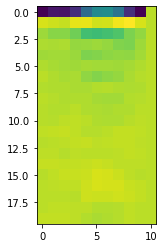

In [10]:
plt.imshow(X_train[100, :, :, 0])
print(y_train[100])

## ANN model 

In [11]:
# one hot encode our targets for multiclass classification
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [12]:
# reshape the data back to one MFCC array per observation
X_train = X_train.reshape(X_train.shape[0], buckets, max_len)
X_test = X_test.reshape(X_test.shape[0], buckets, max_len)

In [13]:
X_train.shape,  y_train.shape, X_test.shape, y_test.shape

((6617, 20, 11), (6617,), (2837, 20, 11), (2837,))

In [49]:
epochs = 500
batch_size = 32
num_classes = 4

# Instansiate model
model = Sequential()
model.add(Flatten(input_shape=(buckets, max_len)))
model.add(Dense(25,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [50]:
# Compile model
model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 220)               0         
                                                                 
 dense_9 (Dense)             (None, 25)                5525      
                                                                 
 dense_10 (Dense)            (None, 10)                260       
                                                                 
 dense_11 (Dense)            (None, 4)                 44        
                                                                 
Total params: 5,829
Trainable params: 5,829
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Train our model
es = EarlyStopping(patience=30, restore_best_weights=True)

history = model.fit(X_train, y_train_hot, 
                    validation_split=0.3, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1, 
                    callbacks=[es])

Epoch 1/500
145/145 [==============================] - 0s 2ms/step - loss: 8.1857 - accuracy: 0.2578 - val_loss: 1.4825 - val_accuracy: 0.2744
Epoch 2/500
145/145 [==============================] - 0s 1ms/step - loss: 1.4514 - accuracy: 0.2807 - val_loss: 1.4066 - val_accuracy: 0.2895
Epoch 3/500
145/145 [==============================] - 0s 2ms/step - loss: 1.3903 - accuracy: 0.3077 - val_loss: 1.3879 - val_accuracy: 0.3218
Epoch 4/500
145/145 [==============================] - 0s 2ms/step - loss: 1.3525 - accuracy: 0.3494 - val_loss: 1.3552 - val_accuracy: 0.3731
Epoch 5/500
145/145 [==============================] - 0s 2ms/step - loss: 1.3071 - accuracy: 0.3934 - val_loss: 1.3176 - val_accuracy: 0.4053
Epoch 6/500
145/145 [==============================] - 0s 1ms/step - loss: 1.2638 - accuracy: 0.4202 - val_loss: 1.2871 - val_accuracy: 0.4270
Epoch 7/500
145/145 [==============================] - 0s 1ms/step - loss: 1.2247 - accuracy: 0.4366 - val_loss: 1.2580 - val_accuracy: 0.4386

Epoch 58/500
145/145 [==============================] - 0s 1ms/step - loss: 0.3551 - accuracy: 0.8426 - val_loss: 0.9154 - val_accuracy: 0.7503
Epoch 59/500
145/145 [==============================] - 0s 1ms/step - loss: 0.3629 - accuracy: 0.8413 - val_loss: 0.7916 - val_accuracy: 0.7538
Epoch 60/500
145/145 [==============================] - 0s 1ms/step - loss: 0.3681 - accuracy: 0.8404 - val_loss: 0.7693 - val_accuracy: 0.7543
Epoch 61/500
145/145 [==============================] - 0s 1ms/step - loss: 0.3341 - accuracy: 0.8549 - val_loss: 0.7661 - val_accuracy: 0.7457
Epoch 62/500
145/145 [==============================] - 0s 1ms/step - loss: 0.3338 - accuracy: 0.8573 - val_loss: 0.8004 - val_accuracy: 0.7543
Epoch 63/500
145/145 [==============================] - 0s 1ms/step - loss: 0.3095 - accuracy: 0.8607 - val_loss: 0.8347 - val_accuracy: 0.7608
Epoch 64/500
145/145 [==============================] - 0s 2ms/step - loss: 0.3162 - accuracy: 0.8646 - val_loss: 0.8871 - val_accuracy:

In [53]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.title('Train loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

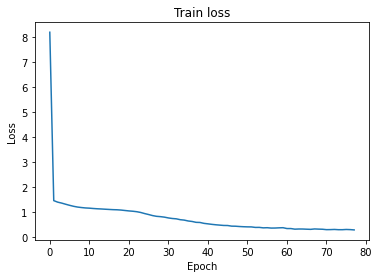

In [54]:
plot_history(history)

In [55]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

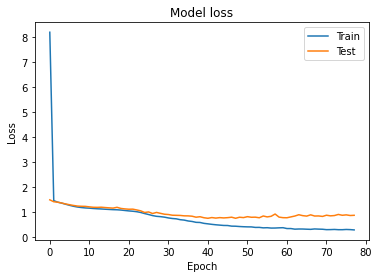

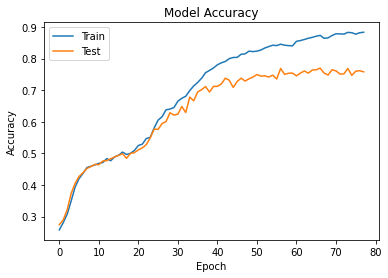

In [56]:
plot_loss_accuracy(history)